# Physics-informed neural networks for the solution of 1 dimensional equations

In [25]:
import os
# Surpress unnecessary output from tensorflow package
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import necessary functions/ packages
from PINNLearning.data import gen_data, set_boundaries, simp_sol, simp_sim, add_noise, simp_sol_var_mat
from PINNLearning.training import learning_rate_schedule, train, oneD_loss
from PINNLearning.models import create_model
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import keras

We first need to set some global values and settings:

In [2]:
# Plot settings
plt.close('all')
plt.rcParams['font.family'] = 'Ubuntu Nerd Font'
plt.rcParams['font.size'] = 10

# Dimensions of the simulation space
lower_bound = 0.0
upper_bound = 1.0

## Initial Testing with boundary conditions

We try to solve the heat equation:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

For this we intially set some simplifications:
* The diffusion factor $\alpha$ is set to 1
* The function is not dependend on the time: $u(x, t) = u(x)$
* The function is only 1 dimensional: $\Delta u(x, t) = \frac{d^2 u(x, t)}{d^2x}$


With these simplifications the upper equation results to:

$u(x) = \dfrac{d^2}{dx^2} u(x)$

With the dirichlet boundary conditions set to:

$u(0) = 1$ and $u(1) = 0$

It is easily possible to adjust these and to change them to Neumann boundary conditions, by adjusting the loss function used for trainging the PINN.

For comparative purposes, the here described boundaries result in the following analytical solution for this equation:

$u(x) = \dfrac{e^{-x} (e^2-e^{2x})}{e^2-1}$

As the model will be created using [Keras](https://keras.io) with [Tensorflow](https://www.tensorflow.org) (Tf) as the backend, all data that is entered into (or is returned from) the model must be in the format of a Tf tensor.
For this, the boundary conditions first need to be converted to a tensors.

Because the differential equation fully describes our problem and (enough) boundary conditions are given, we can adopt an unsupervied learning regime (data points only entail an x value, no correct y value).
In line with this, the training data can just be (by choice also randomly) generated accross the problem space from above but must be ultimately converted to a Tf tensor.
The dimenions of this tensor are important as Tf automatically generates the input layer of the neural network from this. Tf uses the _„row-major“_ storage format, thereby every **row** is a seperate data point and every **column** is a seperte input feature.


When creating the model, a lot of hyperparameters, such as the learning rate, the number of epochs (alternatively here the minimal loss-improvement threashold) or the dimensions of the network itself, can be adjusted.
For simple problems like this one, this is mostly not necessary. However, for larger and more resource intensive problems it can be vital to boost the performance. An examplery implementation of such an **Hyperparameter Optimizaion (HPO) Algorithm** together with an **Neural Architectur Search (NAS) Algorithm** can be found in the `HPO & NAS` notebook.
For these initiall problems we do without it.
In some cases, e.g. the learning rate, a dynamic change over the course of the trainig time can help with the convergence of the algorithm. This is called Dynamic Algorithm Configuration (DAC), implemented here as a learning rate schedule.
Finding the best start/stop/step values can be seen mostly as an seperate Reinforcement Learning task. However, diverse heuristics have been formulated that should perform sufficiantly well for many problems.


Furthermore, for all implementations here it first checks if the model is already trained and entailed in the subdirectory `data`. If this is the case, the (re)training will be suspendend (but can be manually forced). Otherwise the model will be automatically trained and a loss-time development graph will be printed.

In [3]:
# Set the boundary conditions
x_bc, y_bc = set_boundaries([[0.0], [1.0]], [[1.0], [0.0]])

# Create the training data
x_train = gen_data(lower_bound, upper_bound, 100)

# Create the model with fixed sizes
model = create_model(3, 50)

# Create a learning rate schedule
# The purpose of which is to make learning more robust and increase speed
lr_schedule = learning_rate_schedule(1e-3, 1000, 0.9)

# Train the model if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model = keras.models.load_model('./data/simp_initial.keras')
except Exception as e:
    error_time = train(model, x_train, x_bc, y_bc, oneD_loss, lr_schedule, threshold=1e-8)
    model.save('./data/simp_initial.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(0.001, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()

When the model is finished training, it needs to be tested against a more general case (called validation).
For this purpose, more data points must be gernerated and evaluated accross the problem space – the points that the model was trained on **CAN NOT** be part of this set!
Although this practice is more important for models that are required to deliver good gerneral performance (which is obviously not the case for models that return the specifc solution to an equation), it is still a good indicator if the model has properly trained on the data.

As can probably be seen here the loss over this validation data set will often be greater than the final training loss. As long as the difference is not orders of magnitudes, this still indicates a good performing model.

For further testing of the resulting model, the analytical solution is also inferenced accorss the validation data set. A graphical comparison is presented below.

The loss over the validation data is: 2.446438656988903e-06


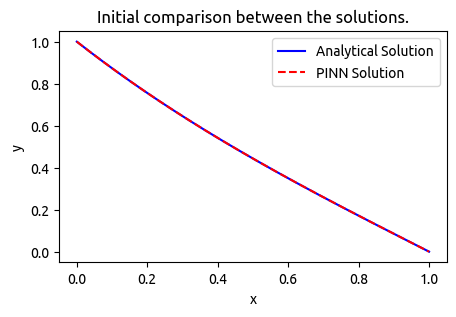

In [4]:
x_test = gen_data(lower_bound, upper_bound, 1000)

# Calculate the loss over the test data
val_loss = oneD_loss(model, x_test, x_bc, y_bc)
print(f"The loss over the validation data is: {val_loss}")

# Convert the returned Tf tensor to numpy for plotting
y_pred = model(x_test).numpy()
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()

## Initial Equation without boundary conditions

In some situations (typically more practical applications), the differential equations fully describing the problem can not be found or not all necessary boundary conditions are given.
However, as long as governing equations can be formulated this situation can still be solved.

For this purpose, the loss function needs to be adjusted to incorporate **real world mesurement data**. 

This however, also introduces the problem of noice in the traing data and must be done carfully.

In the simplified problem from above, this situation is imitated by removing the boundary conditions and switching to a supervised learning regime (all data points now contain an x- and an y-value).

The "measured" training data is gathered by sampling the y-values once from the analytic solution (no noice in the data – ideal measurements) and once from an iterative finite-differences based simulation (noicy measurements). Both follow from the previously generated x-values in the training data set. A comparison between these is shown below.

In this case we will not be using a validaten data set, as the simulation can not handle the enlarged number of data points in an appropriate time or with appropriate resources. This is by the way not a problem of the PINN, which constitutes the main reason why the utilisation of PINNs poses an intresting option.

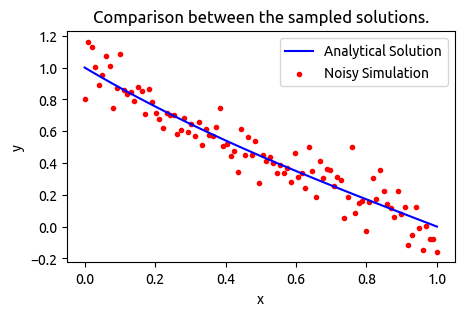

In [5]:
# Simulate the measurement data by generating 
# the different y-Values for the training data
y_train_sim, y_train_noisy = simp_sim(x_train, y_bc, noise_level=0.2)
y_train_true = simp_sol(x_train)
# FYI: As the y-values are only used to compute the loss and
# are thus not directly entered into the PINN, they do not
# need to be a Tf tensor!


plt.figure(figsize=(5, 3))
plt.plot(x_train, y_train_true, 'b', label="Analytical Solution")
plt.scatter(x_train, y_train_noisy, c='r', label='Noisy Simulation', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the sampled solutions.')
plt.show()

The training is just a repeat of the same from above. 
Although there is a slight abuse of the implementation here. As the loss over the boundary conditions is computed in the same way as the loss accross the trainig data, these data points are entered into the training function below as the "boundary conditions".

The process is repeated equivalently for both data sets.

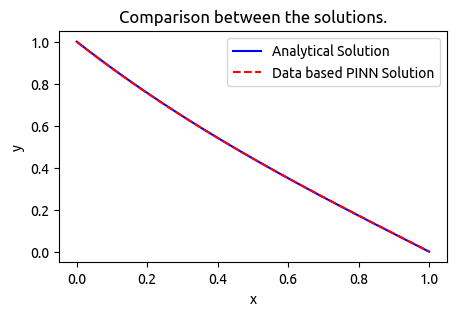

In [6]:
# Create 2 models, one for each y-data
model2 = create_model(3, 50)
model3 = create_model(3, 50)


# Train the model for the true y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model2 = keras.models.load_model('./data/simp_data_true.keras')
except Exception as e:
    error_time = train(model2, x_train, x_train, y_train_true, oneD_loss, lr_schedule, threshold=1e-8)
    model2.save('./data/simp_data_true.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(0.001, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred2 = model2(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred2, 'r--', label='Data based PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

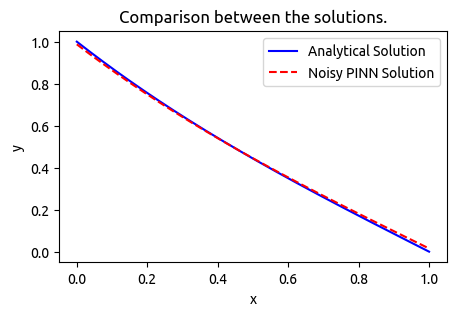

In [7]:
# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model3 = keras.models.load_model('./data/simp_data_noisy.keras')
except Exception as e:
    error_time = train(model3, x_train, x_train, y_train_noisy, oneD_loss, lr_schedule, threshold=1e-8)
    model3.save('./data/simp_data_noisy.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(0.001, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred3 = model3(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred3, 'r--', label='Noisy PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

It is obvious that the PINN trained on the ideal data perfectly models the analytical solution. Therefore, it is clear, that using this option, missing parts of the differential equation or the boundary conditions can be successfully substituted.


It can also be seen, that the model trained with the noisy data still properly learned the function. Playing around with the amount of noise added to the data above, this holds true for **all** configurations.
This follows from the choice of the loss-term as mean squarred error and the centering of the noise around the true value. For this reason it is important that all measurements are accurate (but not necessarily precise, allowing for e.g. random noise) and thus the absence of e.g. offset errors can be guaranteed.


Comparing both resulting models, in the very most cases the one trained on the noisy data demonstrates a larger remaining error value. This should improve in tendency with increasing the number of data points. However, the increased accuracy of the model must obviously be balanced against the effort of taking the additional measurements.


As such it is important to consider the error in the "predicted" values inferenced from the PINN for further use.

In [8]:
# Compute some numbers for comparison between these methods
err2 = y_true - y_pred2
err3 = y_true - y_pred3

# Get the max. and mean absolute error for each model
mae2 = np.mean(abs(err2))
max2 = max(abs(err2))[0]

mae3 = np.mean(abs(err3))
max3 = max(abs(err3))[0]

# Calculate the normalized mae as percentage error
mape2 = 100 * mae2/np.mean(y_true)
mape3 = 100 * mae3/np.mean(y_true)

# Print it nicely
sign1 = '>' if mae2 > mae3 else '<'
sign2 = '>' if max2 > max3 else '<'

print(20*" " + "True Solution" + 18 * " " + "Noisy Solution")
print(f"Average Error: {mae2} ({mape2:.2f}%)" + 2*" " + sign1 + f" {mae3} ({mape3:.2f}%)")
print(f"Maximum Error: {max2}" + 10*" " + sign2 + f" {max3}")

                    True Solution                  Noisy Solution
Average Error: 0.0006284255068749189 (0.14%)  < 0.006897184997797012 (1.49%)
Maximum Error: 0.0012981281615793705          < 0.015179391019046307


In [9]:
# Wrapper for the training of the individual models
def train_model(i):
    mod = create_model(3, 50)
    y_data = add_noise(y_train_sim, 0.2)
    train(mod, x_train, x_train, y_data, oneD_loss, lr_schedule, threshold=1e-8, write=False)
    print(f"Run {i + 1} completed!")
    return mod(x_test).numpy()

num_models = 18  # Number of models to be trained
# FYI: should be at least 30 for statistically reliable results
num_jobs = 6  # How many should be trained in parallel
#FYI: should not be higher than num of CPU cores!

# Parallelize the training to reduce training time
tasks = [delayed(train_model)(i) for i in range(num_models)]
y_pred_quant = list(Parallel(num_jobs)(tasks))

# Evaluate the pervemtage error for all models
for i in range(len(y_pred_quant)):
    err = y_true - y_pred_quant[i]
    y_pred_quant[i] = 100 * np.mean(abs(err))/np.mean(y_true)

print(f"The quantified error: {np.mean(y_pred_quant):.4f}% ± {np.std(y_pred_quant):.2f}%")

KeyboardInterrupt: 

# With variing material conditons

We try to solve the heat equation again:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

For this we take the same simplifications as before, except for the diffusion factor $\alpha$.

Here we consider an inhomogenous and non-isotropic material as such we have to set the diffusion constant to: $\alpha(x)$

As such the equation results to
$u(x) = \alpha(x) \dfrac{d^2}{dx^2} u(x)$

We are also keeping the same boundary conditions as before:

$u(0) = 1$ and $u(1) = 0$

We these boundarys the analytical solution results to the same as before but scaled with $\sqrt(\frac{1}{\alpha(x)})$:

$u(x) = \dfrac{e^{\sqrt(-\frac{1}{\alpha(x)}) \cdot x} (e^{2 \cdot \sqrt(\frac{1}{\alpha(x)})} - e^{2 \cdot \sqrt(\frac{1}{\alpha(x)}) x})}{e^{2 \cdot \sqrt(\frac{1}{\alpha(x)})} - 1}$

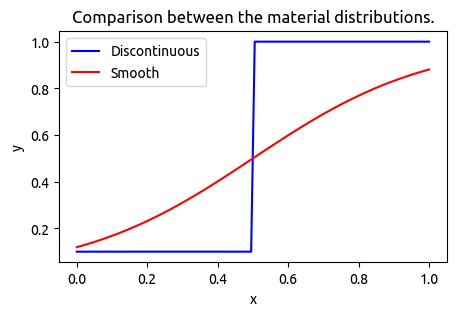

In [34]:
# Create the distribution accross the material


# creatig a discontinuous change of material proposition
def alph_discon(x):
    # step function, 1e-3 to prevent deviding by 0
    return np.where(x < 0.5, lower_bound + 1e-1, upper_bound)

# creating a smooth change of material proposition
def alph_smooth(x, k=4):
    # sigmoid function, automatiaclly in [0, 1]
    sigmoid = 1 / (1 + np.exp(-k * (x - 0.5)))
    # making sure the result is not too small because of overflow
    return np.clip(sigmoid, 1e-3, 1) ## --> discinuity


# print it just for looking
data = np.linspace(0, 1, 100)
data_disc = alph_discon(data)
data_smooth = alph_smooth(data)

plt.figure(figsize=(5, 3))
plt.plot(data, data_disc, 'b', label="Discontinuous")
plt.plot(data, data_smooth, c='r', label='Smooth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the material distributions.')
plt.show()

Epoch 100: Loss = 0.18226104974746704
Epoch 200: Loss = 0.020271269604563713
Epoch 300: Loss = 0.015969688072800636
Epoch 400: Loss = 0.014793056063354015
Epoch 500: Loss = 0.014028077013790607
Epoch 600: Loss = 0.01370712835341692
Epoch 700: Loss = 0.01267432514578104
Epoch 800: Loss = 0.011786838062107563
Epoch 900: Loss = 0.010091600008308887
Epoch 1000: Loss = 0.010307862423360348
Epoch 1100: Loss = 0.005663169547915459
Epoch 1200: Loss = 0.005515347700566053
Epoch 1300: Loss = 0.005369076505303383
Epoch 1400: Loss = 0.005259071011096239
Epoch 1500: Loss = 0.005031968001276255
Epoch 1600: Loss = 0.005070527549833059
Epoch 1700: Loss = 0.004686856176704168
Epoch 1800: Loss = 0.004532501567155123
Last Epoch 1870: last Loss = 0.004430694971233606


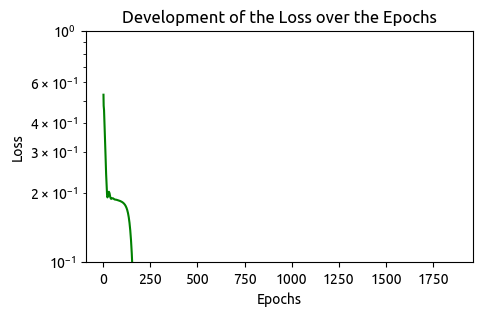

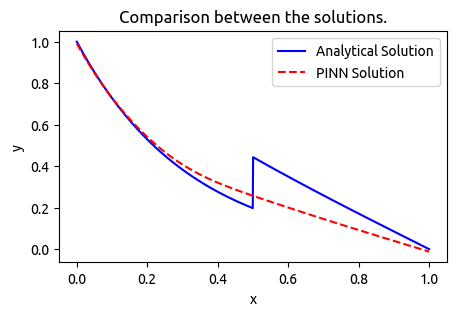

In [31]:
# Create a model
model4 = create_model(3, 50)

# Create closure function to set alpha and use same fitting function
def loss(model, inp, x_bc, y_bc):
    return oneD_loss(model, inp, x_bc, y_bc, alph_discon)


# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    raise Exception

    model4 = keras.models.load_model('./data/simp_mat_var_disc.keras')
except Exception as e:
    error_time = train(model4, x_train, x_bc, y_bc, loss, lr_schedule, threshold=1e-8)
    model4.save('./data/simp_mat_var_disc.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(0.1, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred4 = model4(x_test).numpy()
# Recalculate y_true
y_true = simp_sol_var_mat(x_test, alph_discon)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred4, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

Epoch 100: Loss = 0.10412658005952835
Epoch 200: Loss = 0.00032068733708001673
Epoch 300: Loss = 0.0002860943495761603
Epoch 400: Loss = 0.0002579368301667273
Epoch 500: Loss = 0.00022859776800032705
Epoch 600: Loss = 0.00020942222909070551
Epoch 700: Loss = 0.00018420883861836046
Epoch 800: Loss = 0.000720954907592386
Epoch 900: Loss = 0.00015193743456620723
Epoch 1000: Loss = 0.00013848610979039222
Last Epoch 1061: last Loss = 0.00013118782953824848


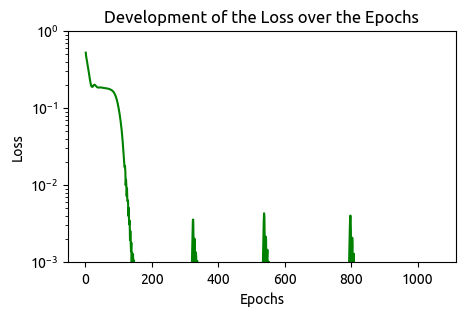

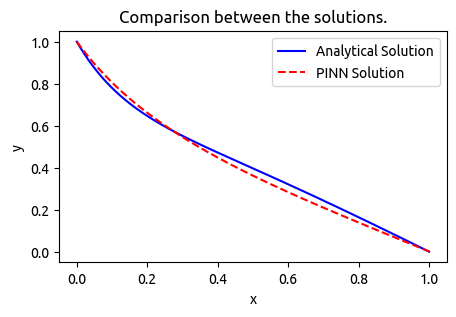

In [35]:
# Create a model
model5 = create_model(3, 50)

# Create closure function to set alpha and use same fitting function
def loss(model, inp, x_bc, y_bc):
    return oneD_loss(model, inp, x_bc, y_bc, alph_smooth)


# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    raise Exception

    model5 = keras.models.load_model('./data/simp_mat_var_smooth.keras')
except Exception as e:
    error_time = train(model5, x_train, x_bc, y_bc, loss, lr_schedule, threshold=1e-8)
    model5.save('./data/simp_mat_var_smooth.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(0.001, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred5 = model5(x_test).numpy()
# Recalculate y_true
y_true = simp_sol_var_mat(x_test, alph_smooth)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred5, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()